In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import math
from skimage.metrics import structural_similarity as ssim
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F
from torchvision import models

class DepthDataset(torch.utils.data.Dataset):
    def __init__(self, depth_dir, transform=None, max_images=None):
        self.depth_dir = depth_dir
        self.depth_images = os.listdir(depth_dir)
        if max_images:
            self.depth_images = self.depth_images[:max_images]
        self.transform = transform

    def __len__(self):
        return len(self.depth_images)

    def __getitem__(self, idx):
        depth_path = os.path.join(self.depth_dir, self.depth_images[idx])
        depth_image = Image.open(depth_path).convert("L")  # Grayscale
        rgb_image = Image.open(depth_path).convert("RGB")  # RGB

        if self.transform:
            depth_image = self.transform(depth_image)
            rgb_image = self.transform(rgb_image)

        return {'depth': depth_image, 'rgb': rgb_image}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

folder_path = "./test2017"
dataset = DepthDataset(folder_path, transform=transform, max_images=40000)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)



In [2]:
class UNetGenerator(nn.Module):
    def __init__(self):
        super(UNetGenerator, self).__init__()

        self.enc1 = nn.Sequential(nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1), nn.ReLU())
        self.enc2 = nn.Sequential(nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.enc3 = nn.Sequential(nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU())
        self.enc4 = nn.Sequential(nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(512), nn.ReLU())

        self.bottleneck = nn.Sequential(nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1), nn.ReLU())

        self.dec4 = nn.Sequential(nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(512), nn.ReLU())
        self.dec3 = nn.Sequential(nn.ConvTranspose2d(1024, 256, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(256), nn.ReLU())
        self.dec2 = nn.Sequential(nn.ConvTranspose2d(512, 128, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(128), nn.ReLU())
        self.dec1 = nn.Sequential(nn.ConvTranspose2d(256, 64, kernel_size=4, stride=2, padding=1), nn.BatchNorm2d(64), nn.ReLU())
        self.final = nn.Sequential(nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1), nn.Sigmoid())  # Génère 256x256

    def forward(self, x):
        e1 = self.enc1(x)  # (1 -> 64)
        e2 = self.enc2(e1)  # (64 -> 128)
        e3 = self.enc3(e2)  # (128 -> 256)
        e4 = self.enc4(e3)  # (256 -> 512)

        b = self.bottleneck(e4)  # (512 -> 512)

        d4 = self.dec4(b)  # (512 -> 512)
        d3 = self.dec3(torch.cat([d4, e4], dim=1))  # Concatenate with e4 (512 + 512 -> 1024)
        d2 = self.dec2(torch.cat([d3, e3], dim=1))  # Concatenate with e3 (256 + 256 -> 512)
        d1 = self.dec1(torch.cat([d2, e2], dim=1))  # Concatenate with e2 (128 + 128 -> 256)
        df = self.final(d1)
        return df

    
class PatchGANDiscriminator(nn.Module):
    def __init__(self):
        super(PatchGANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1),  # Input (RGB + Grayscale)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1),
            nn.Sigmoid()  # Output patch probabilities
        )

    def forward(self, gray_image, rgb_image):
        #print(gray_image.shape)
        #print(rgb_image.shape)
        x = torch.cat([gray_image, rgb_image], dim=1) 
        #print(x.shape)
        x = self.model(x)
        #print(x.shape)
        return x 
    
class GANDiscriminator(nn.Module):
    def __init__(self):
        super(GANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(4, 64, kernel_size=4, stride=2, padding=1),  # Input (RGB + Grayscale)
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Conv2d(256, 512, kernel_size=4, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0),
            nn.Sigmoid() 
        )

    def forward(self, gray_image, rgb_image):
        #print(gray_image.shape)
        #print(rgb_image.shape)
        x = torch.cat([gray_image, rgb_image], dim=1) 
        #print(x.shape)
        x = self.model(x)
        x = x.view(x.size(0), -1) 
        #print(x.shape)
        return x 


In [3]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(1.0 / math.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, multichannel=True, data_range=1.0,win_size=3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)

gen_path = "unet_generator_patch_bce.pth"
dis_path = "patch_gan_discriminator_bce.pth"

if os.path.exists(gen_path):
    generator.load_state_dict(torch.load(gen_path))
    print("Generator loaded.")

if os.path.exists(dis_path):
    discriminator.load_state_dict(torch.load(dis_path))
    print("Discriminator loaded.")

# TensorBoard Writer
writer = SummaryWriter(log_dir="runs/training_logs-patch_bce")

criterion_GAN = nn.BCELoss()  
criterion_L1 = nn.L1Loss() 
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 100
for epoch in range(epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0
    psnr_values = []
    ssim_values = []

    for batch in dataloader:
        depth_images = batch['depth'].to(device)  
        rgb_images = batch['rgb'].to(device)      

        optimizer_D.zero_grad()
        fake_images = generator(depth_images) 


        real_labels = torch.ones_like(discriminator(depth_images, rgb_images)).to(device) 
        fake_labels = torch.zeros_like(discriminator(depth_images, fake_images.detach())).to(device)


        real_loss = criterion_GAN(discriminator(depth_images, rgb_images), real_labels)
        fake_loss = criterion_GAN(discriminator(depth_images, fake_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        fake_loss = criterion_GAN(discriminator(depth_images, fake_images), real_labels)
        l1_loss = criterion_L1(fake_images, rgb_images) * 100.0
        g_loss = fake_loss + l1_loss
        g_loss.backward()
        optimizer_G.step()

        for j in range(fake_images.size(0)):
            true_image = rgb_images[j].detach().cpu().numpy().transpose(1, 2, 0)
            pred_image = fake_images[j].detach().cpu().numpy().transpose(1, 2, 0)

            psnr_values.append(calculate_psnr(true_image, pred_image))
            ssim_values.append(calculate_ssim(true_image, pred_image))

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()



    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    writer.add_scalar("Loss/Discriminator", epoch_d_loss / len(dataloader), epoch)
    writer.add_scalar("Loss/Generator", epoch_g_loss / len(dataloader), epoch)
    writer.add_scalar("Metrics/PSNR", avg_psnr, epoch)
    writer.add_scalar("Metrics/SSIM", avg_ssim, epoch)

    torch.save(generator.state_dict(), gen_path)
    torch.save(discriminator.state_dict(), dis_path)

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {d_loss.item():.4f}, G Loss: {g_loss.item():.4f}")
    writer.close()


Generator loaded.
Discriminator loaded.


/tmp/ipykernel_1504306/4098955196.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(gen_path))
/tmp/ipykernel_1504306/4098955196.py:2

Epoch [1/100], D Loss: 0.0003, G Loss: 12.3482
Epoch [2/100], D Loss: 0.0012, G Loss: 14.8635
Epoch [3/100], D Loss: 0.4464, G Loss: 7.4314
Epoch [4/100], D Loss: 0.0000, G Loss: 18.8524
Epoch [5/100], D Loss: 0.0000, G Loss: 15.0706
Epoch [6/100], D Loss: 0.0010, G Loss: 14.5451
Epoch [7/100], D Loss: 0.0000, G Loss: 15.7494
Epoch [8/100], D Loss: 0.0028, G Loss: 13.7190
Epoch [9/100], D Loss: 0.0004, G Loss: 16.0326
Epoch [10/100], D Loss: 0.6000, G Loss: 6.6195
Epoch [11/100], D Loss: 0.0002, G Loss: 15.7276
Epoch [12/100], D Loss: 0.0004, G Loss: 12.4630
Epoch [13/100], D Loss: 0.0000, G Loss: 17.1658
Epoch [14/100], D Loss: 0.0009, G Loss: 11.7648
Epoch [15/100], D Loss: 0.0000, G Loss: 18.2861
Epoch [16/100], D Loss: 0.3364, G Loss: 9.2877
Epoch [17/100], D Loss: 0.6217, G Loss: 7.0418
Epoch [18/100], D Loss: 0.0122, G Loss: 9.4160
Epoch [19/100], D Loss: 0.0000, G Loss: 19.5417
Epoch [20/100], D Loss: 0.7290, G Loss: 5.6445
Epoch [21/100], D Loss: 0.0010, G Loss: 15.8781
Epoch [

In [4]:
folder_path = "./test2017"
dataset = DepthDataset(folder_path, transform=transform, max_images=15000)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)

In [ ]:
torch.cuda.empty_cache()

generator = UNetGenerator().to(device)
discriminator = GANDiscriminator().to(device)

gen_path = "unet_generator_global_bce.pth"
dis_path = "global_gan_discriminator_bce.pth"

if os.path.exists(gen_path):
    generator.load_state_dict(torch.load(gen_path))
    print("Generator loaded.")

if os.path.exists(dis_path):
    discriminator.load_state_dict(torch.load(dis_path))
    print("Discriminator loaded.")

writer = SummaryWriter(log_dir="runs/training_logs-global1_bce")

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

epochs = 100
for epoch in range(epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0
    psnr_values = []
    ssim_values = []

    for batch in dataloader:
        depth_images = batch['depth'].to(device)  
        rgb_images = batch['rgb'].to(device)      

        optimizer_D.zero_grad()
        fake_images = generator(depth_images)

        real_labels = torch.ones_like(discriminator(depth_images, rgb_images)).to(device) 
        fake_labels = torch.zeros_like(discriminator(depth_images, fake_images.detach())).to(device)

        real_loss = criterion_GAN(discriminator(depth_images, rgb_images), real_labels)
        fake_loss = criterion_GAN(discriminator(depth_images, fake_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        fake_loss = criterion_GAN(discriminator(depth_images, fake_images), real_labels)
        l1_loss = criterion_L1(fake_images, rgb_images) * 100.0
        g_loss = fake_loss + l1_loss
        g_loss.backward()
        optimizer_G.step()


        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

        for i in range(fake_images.size(0)):
            true_image = rgb_images[j].detach().cpu().numpy().transpose(1, 2, 0)
            pred_image = fake_images[j].detach().cpu().numpy().transpose(1, 2, 0)

            psnr_values.append(calculate_psnr(true_image, pred_image))
            ssim_values.append(calculate_ssim(true_image, pred_image))


        avg_d_loss = epoch_d_loss / len(dataloader)
        avg_g_loss = epoch_g_loss / len(dataloader)
        avg_psnr = np.mean(psnr_values)
        avg_ssim = np.mean(ssim_values)

        writer.add_scalar("Loss/Discriminator", avg_d_loss, epoch)
        writer.add_scalar("Loss/Generator", avg_g_loss, epoch)
        writer.add_scalar("Metrics/PSNR", avg_psnr, epoch)
        writer.add_scalar("Metrics/SSIM", avg_ssim, epoch)


    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {epoch_d_loss / len(dataloader):.4f}, G Loss: {epoch_g_loss / len(dataloader):.4f}")
    torch.save(generator.state_dict(), gen_path)
    torch.save(discriminator.state_dict(), dis_path)
    
writer.close()


Generator loaded.


/tmp/ipykernel_1504306/3576821629.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load(gen_path))


Epoch [1/100], D Loss: 0.5601, G Loss: 7.5538
Epoch [2/100], D Loss: 0.4727, G Loss: 8.1589
Epoch [3/100], D Loss: 0.2918, G Loss: 9.7349
Epoch [4/100], D Loss: 0.1470, G Loss: 12.7829
Epoch [5/100], D Loss: 0.3970, G Loss: 8.6484
Epoch [6/100], D Loss: 0.1432, G Loss: 11.6223
Epoch [7/100], D Loss: 0.0116, G Loss: 15.9609
Epoch [8/100], D Loss: 0.1921, G Loss: 10.9529
Epoch [9/100], D Loss: 0.0624, G Loss: 13.1585
Epoch [10/100], D Loss: 0.1103, G Loss: 12.7975
Epoch [11/100], D Loss: 0.0002, G Loss: 15.2856
Epoch [12/100], D Loss: 0.1662, G Loss: 14.4033
Epoch [13/100], D Loss: 0.0757, G Loss: 12.9376
Epoch [14/100], D Loss: 0.2137, G Loss: 10.6995
Epoch [15/100], D Loss: 0.0467, G Loss: 13.3043
Epoch [16/100], D Loss: 0.1756, G Loss: 12.0161
Epoch [17/100], D Loss: 0.1259, G Loss: 12.0102
Epoch [18/100], D Loss: 0.0006, G Loss: 14.1902
Epoch [19/100], D Loss: 0.0000, G Loss: 16.6393
Epoch [20/100], D Loss: 0.2478, G Loss: 11.7946
Epoch [21/100], D Loss: 0.1058, G Loss: 12.5409
Epoch

In [ ]:
torch.cuda.empty_cache()

generator = UNetGenerator().to(device)
discriminator = PatchGANDiscriminator().to(device)

gen_path = "unet_generator_patch_perc.pth"
dis_path = "patch_gan_discriminator_perc.pth"

if os.path.exists(gen_path):
    generator.load_state_dict(torch.load(gen_path))
    print("Generator loaded.")

if os.path.exists(dis_path):
    discriminator.load_state_dict(torch.load(dis_path))
    print("Discriminator loaded.")

writer = SummaryWriter(log_dir="runs/training_logs-patch_perc")

def get_vgg19_features():
    """
    Charge VGG19 pré-entraîné et sélectionne des couches spécifiques pour extraire les caractéristiques(bas niveu , moyen , haut niveau)
    """
    vgg = models.vgg19(pretrained=True).features
    selected_layers = [3, 8, 17]  # Correspond à relu1_2, relu2_2, relu4_1
    return torch.nn.Sequential(*[vgg[i] for i in selected_layers]).eval()

vgg_features = get_vgg19_features().to(device)

for param in vgg_features.parameters():
    param.requires_grad = False

def perceptual_loss(generated, target):

    gen_features = vgg_features(generated)
    target_features = vgg_features(target)
    loss = F.l1_loss(gen_features, target_features)
    return loss

epoch = 100
for epoch in range(epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0
    epoch_perc_loss = 0
    psnr_values = []
    ssim_values = []

    for batch in dataloader:
        depth_images = batch['depth'].to(device)  
        rgb_images = batch['rgb'].to(device)      

        optimizer_D.zero_grad()
        fake_images = generator(depth_images)

        real_labels = torch.ones_like(discriminator(depth_images, rgb_images)).to(device) 
        fake_labels = torch.zeros_like(discriminator(depth_images, fake_images.detach())).to(device)

        real_loss = criterion_GAN(discriminator(depth_images, rgb_images), real_labels)
        fake_loss = criterion_GAN(discriminator(depth_images, fake_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        fake_loss = criterion_GAN(discriminator(depth_images, fake_images), real_labels)
        l1_loss = criterion_L1(fake_images, rgb_images) * 100.0
        perc_loss = perceptual_loss(fake_images, rgb_images) * 10.0
        g_loss = fake_loss + l1_loss + perc_loss
        g_loss.backward()
        optimizer_G.step()

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        epoch_perc_loss += perc_loss.item()

        for i in range(fake_images.size(0)):
            true_image = rgb_images[j].detach().cpu().numpy().transpose(1, 2, 0)
            pred_image = fake_images[j].detach().cpu().numpy().transpose(1, 2, 0)

            psnr_values.append(calculate_psnr(true_image, pred_image))
            ssim_values.append(calculate_ssim(true_image, pred_image))

    # Moyennes des métriques
    avg_d_loss = epoch_d_loss / len(dataloader)
    avg_g_loss = epoch_g_loss / len(dataloader)
    avg_perc_loss = epoch_perc_loss / len(dataloader)
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    # Log dans TensorBoard
    writer.add_scalar("Loss/Discriminator", avg_d_loss, epoch)
    writer.add_scalar("Loss/Generator", avg_g_loss, epoch)
    writer.add_scalar("Loss/Perceptual", avg_perc_loss, epoch)
    writer.add_scalar("Metrics/PSNR", avg_psnr, epoch)
    writer.add_scalar("Metrics/SSIM", avg_ssim, epoch)

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {epoch_d_loss / len(dataloader):.4f}, G Loss: {epoch_g_loss / len(dataloader):.4f}")
    torch.save(generator.state_dict(), gen_path)
    torch.save(discriminator.state_dict(), dis_path)
writer.close()


In [ ]:
torch.cuda.empty_cache()

generator = UNetGenerator().to(device)
discriminator = GANDiscriminator().to(device)

gen_path = "unet_generator_global_perc.pth"
dis_path = "global_gan_discriminator_perc.pth"

if os.path.exists(gen_path):
    generator.load_state_dict(torch.load(gen_path))
    print("Generator loaded.")

if os.path.exists(dis_path):
    discriminator.load_state_dict(torch.load(dis_path))
    print("Discriminator loaded.")

writer = SummaryWriter(log_dir="runs/training_logs-global_perc")

for epoch in range(epochs):
    epoch_d_loss = 0
    epoch_g_loss = 0
    epoch_perc_loss = 0
    psnr_values = []
    ssim_values = []
    

    for batch in dataloader:
        depth_images = batch['depth'].to(device)  
        rgb_images = batch['rgb'].to(device)      

        optimizer_D.zero_grad()
        fake_images = generator(depth_images)

        real_labels = torch.ones_like(discriminator(depth_images, rgb_images)).to(device) 
        fake_labels = torch.zeros_like(discriminator(depth_images, fake_images.detach())).to(device)

        real_loss = criterion_GAN(discriminator(depth_images, rgb_images), real_labels)
        fake_loss = criterion_GAN(discriminator(depth_images, fake_images.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

        optimizer_G.zero_grad()
        fake_loss = criterion_GAN(discriminator(depth_images, fake_images), real_labels)
        l1_loss = criterion_L1(fake_images, rgb_images) * 100.0
        perc_loss = perceptual_loss(fake_images, rgb_images) * 10.0
        g_loss = fake_loss + l1_loss + perc_loss
        g_loss.backward()
        optimizer_G.step()

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()
        epoch_perc_loss += perc_loss.item()


        for i in range(fake_images.size(0)):
            true_image = rgb_images[j].detach().cpu().numpy().transpose(1, 2, 0)
            pred_image = fake_images[j].detach().cpu().numpy().transpose(1, 2, 0)

            psnr_values.append(calculate_psnr(true_image, pred_image))
            ssim_values.append(calculate_ssim(true_image, pred_image))

    avg_d_loss = epoch_d_loss / len(dataloader)
    avg_g_loss = epoch_g_loss / len(dataloader)
    avg_perc_loss = epoch_perc_loss / len(dataloader)
    avg_psnr = np.mean(psnr_values)
    avg_ssim = np.mean(ssim_values)

    writer.add_scalar("Loss/Discriminator", avg_d_loss, epoch)
    writer.add_scalar("Loss/Generator", avg_g_loss, epoch)
    writer.add_scalar("Loss/Perceptual", avg_perc_loss, epoch)
    writer.add_scalar("Metrics/PSNR", avg_psnr, epoch)
    writer.add_scalar("Metrics/SSIM", avg_ssim, epoch)

    print(f"Epoch [{epoch+1}/{epochs}], D Loss: {epoch_d_loss / len(dataloader):.4f}, G Loss: {epoch_g_loss / len(dataloader):.4f}")
    torch.save(generator.state_dict(), gen_path)
    torch.save(discriminator.state_dict(), dis_path)
writer.close()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_ubyte
from piq import niqe

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * np.log10(1.0 / np.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, multichannel=True, data_range=1.0)

def calculate_mae(img1, img2):
    return np.mean(np.abs(img1 - img2))

def calculate_niqe(img):
    img_uint8 = img_as_ubyte(img)
    return niqe(torch.tensor(img_uint8).unsqueeze(0).permute(0, 3, 1, 2) / 255.0).item()


In [ ]:
folder_path = "./val2017"
dataset_tset = DepthDataset(folder_path, transform=transform, max_images=200)
dataloader_test = DataLoader(dataset, batch_size=4, shuffle=False, num_workers=4)

In [ ]:
torch.cuda.empty_cache()



generator = UNetGenerator().to(device)
generator.load_state_dict(torch.load("unet_generator_global_bce.pth", map_location=device))
generator.eval()

def test_model(generator, dataloader, device):
    psnr_values, ssim_values, mae_values, niqe_values = [], [], [], []
    
    generator.eval()
    with torch.no_grad():
        for batch in dataloader:
            depth_images = batch['depth'].to(device)
            rgb_images = batch['rgb'].to(device)

            fake_images = generator(depth_images)

            for i in range(fake_images.size(0)):
                true_image = rgb_images[i].detach().cpu().numpy().transpose(1, 2, 0)
                pred_image = fake_images[i].detach().cpu().numpy().transpose(1, 2, 0)

                psnr_values.append(calculate_psnr(true_image, pred_image))
                ssim_values.append(calculate_ssim(true_image, pred_image))
                mae_values.append(calculate_mae(true_image, pred_image))
                niqe_values.append(calculate_niqe(pred_image))

    return {
        "PSNR": np.mean(psnr_values),
        "SSIM": np.mean(ssim_values),
        "MAE": np.mean(mae_values),
        "NIQE": np.mean(niqe_values)
    }

# Test du Global GAN
metrics = test_model(generator, dataloader_test, device)
print("Metrics for Global GAN:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


In [ ]:
torch.cuda.empty_cache()

generator = UNetGenerator().to(device)
generator.load_state_dict(torch.load("unet_generator_patch_bce.pth", map_location=device))
generator.eval()

# Test du PatchGAN
metrics = test_model(generator, dataloader_test, device)
print("Metrics for PatchGAN:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


In [ ]:
torch.cuda.empty_cache()

generator = UNetGenerator().to(device)
generator.load_state_dict(torch.load("unet_generator_global_perc.pth", map_location=device))
generator.eval()

# Test du Global GAN avec Perceptual Loss
metrics = test_model(generator, dataloader_test, device)
print("Metrics for Global GAN with Perceptual Loss:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


In [ ]:

torch.cuda.empty_cache()

generator = UNetGenerator().to(device)
generator.load_state_dict(torch.load("unet_generator_patch_perc.pth", map_location=device))
generator.eval()

# Test du PatchGAN avec Perceptual Loss
metrics = test_model(generator, dataloader_test, device)
print("Metrics for PatchGAN with Perceptual Loss:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.4f}")


/tmp/ipykernel_156973/934780720.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("unet_generator.pth", map_location=device))


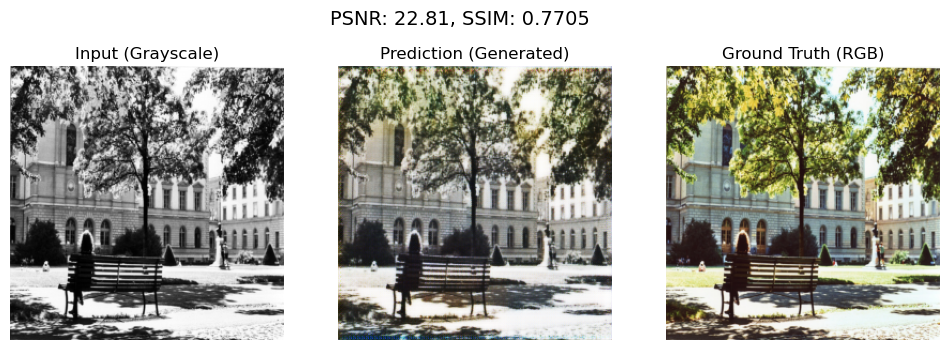

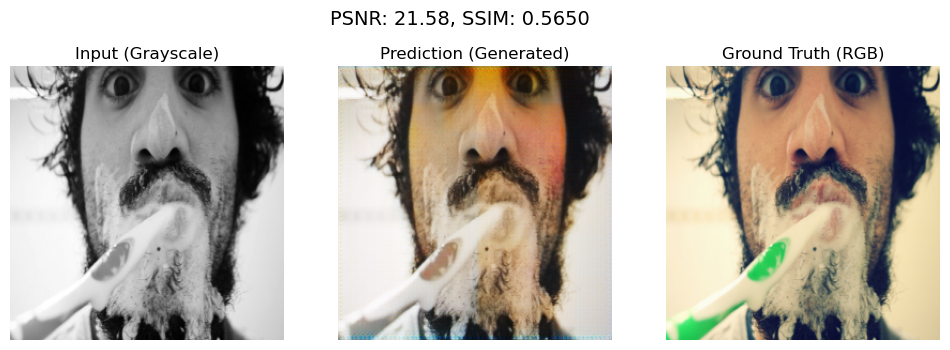

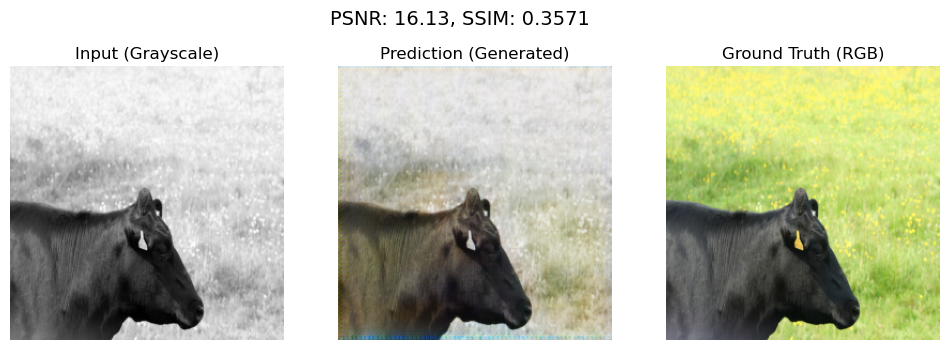

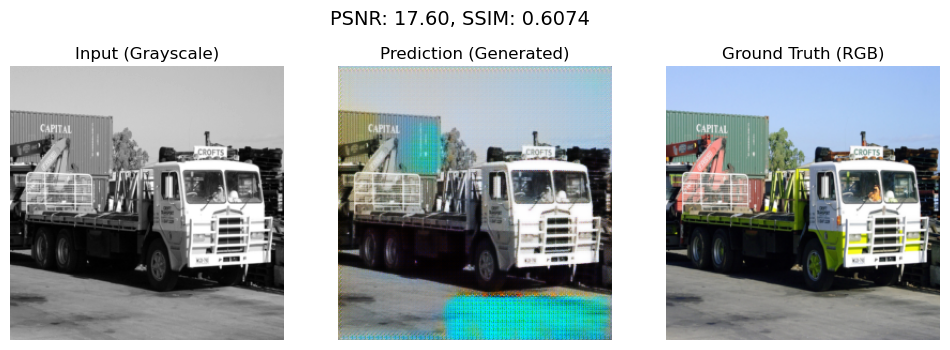

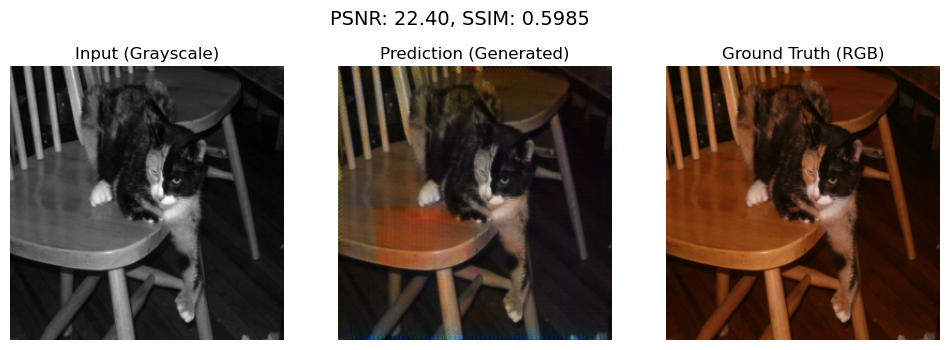

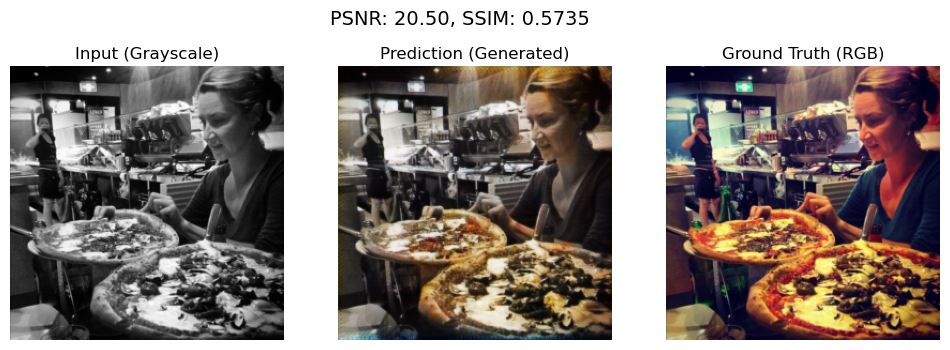

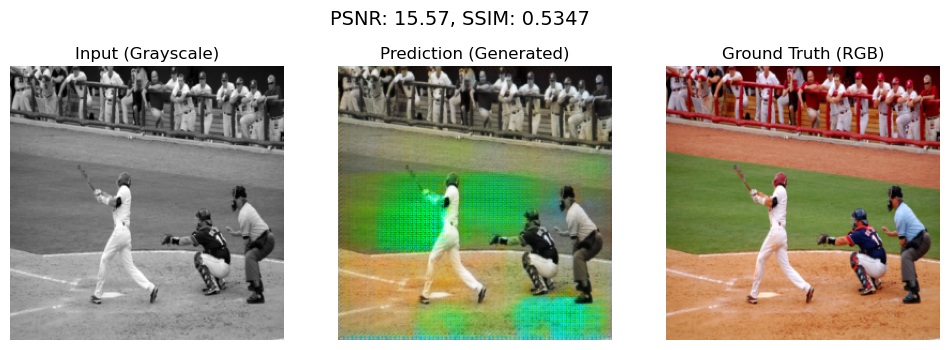

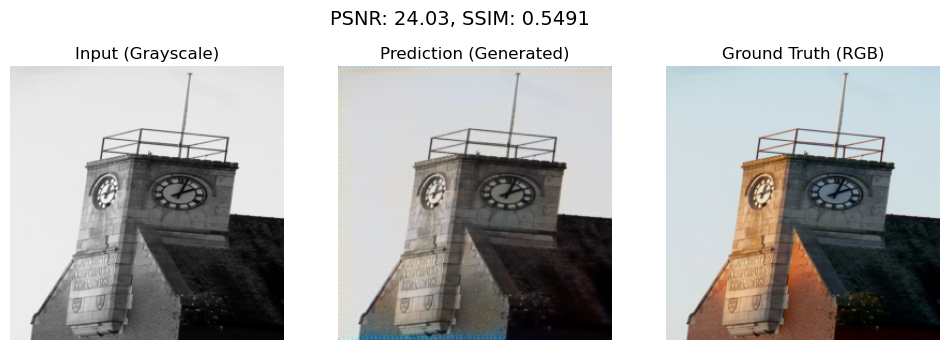

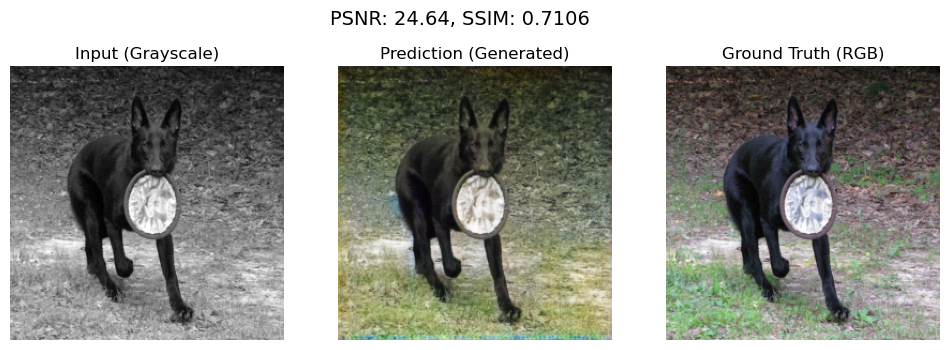

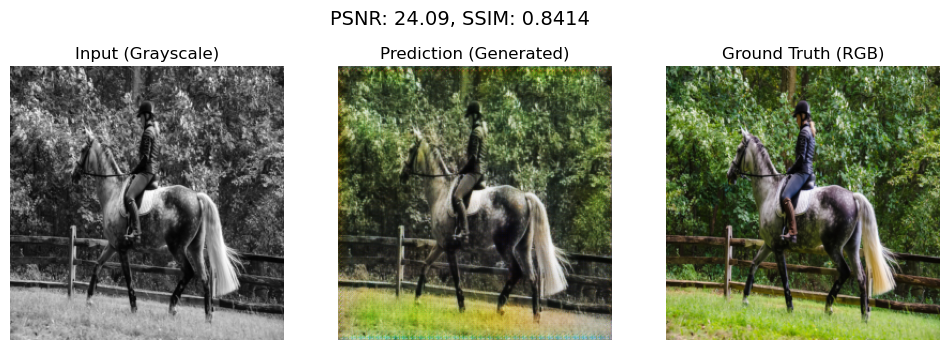

In [ ]:
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim

def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')
    return 20 * math.log10(1.0 / math.sqrt(mse))

def calculate_ssim(img1, img2):
    return ssim(img1, img2, multichannel=True, data_range=1.0,win_size=3)

generator = UNetGenerator().to(device)
generator.load_state_dict(torch.load("unet_generator.pth", map_location=device))
generator.eval()

folder_path = "./val2017"
dataset_test = DepthDataset(folder_path, transform=transform, max_images=40)
dataloader_test = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=4)


def display_predictions(generator, dataloader, device, num_images=5):
    generator.eval()
    images_shown = 0

    with torch.no_grad():
        for batch in dataloader:
            depth_images = batch['depth'].to(device)  # Grayscale input
            rgb_images = batch['rgb'].to(device)     # Ground truth (RGB)

            fake_images = generator(depth_images)

            depth_images_np = depth_images.cpu().numpy()
            fake_images_np = fake_images.cpu().numpy()
            rgb_images_np = rgb_images.cpu().numpy()

            for i in range(len(depth_images)):
                if images_shown >= num_images:
                    break

                gray_image = depth_images_np[i].squeeze()
                pred_image = fake_images_np[i].transpose(1, 2, 0) 
                true_image = rgb_images_np[i].transpose(1, 2, 0)  

                # # Denormalize [-1, 1] -> [0, 1]
                # pred_image = (pred_image + 1) / 2
                # true_image = (true_image + 1) / 2

                psnr_value = calculate_psnr(true_image, pred_image)
                ssim_value = calculate_ssim(true_image, pred_image)

                plt.figure(figsize=(12, 4))
                plt.subplot(1, 3, 1)
                plt.title("Input (Grayscale)")
                plt.imshow(gray_image, cmap='gray')
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("Prediction (Generated)")
                plt.imshow(np.clip(pred_image, 0, 1))
                plt.axis('off')

                plt.subplot(1, 3, 3)
                plt.title("Ground Truth (RGB)")
                plt.imshow(np.clip(true_image, 0, 1))
                plt.axis('off')

                plt.suptitle(f"PSNR: {psnr_value:.2f}, SSIM: {ssim_value:.4f}", fontsize=14)
                plt.show()

                images_shown += 1

            if images_shown >= num_images:
                break

display_predictions(generator, dataloader_test, device,10)